# The Distribution of Wealth and the MPC


This notebook presents a selection of results from the paper [The Distribution of Wealth and the Marginal Propensity to Consume](http://econ.jhu.edu/people/ccarroll/papers/cstwMPC), using the [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit. It sketches the steps that would need to be taken to solve the model using the [dolARK](https://github.com/EconForge/dolARK) modeling system.


In [1]:
# This cell does some standard python setup!

import code.calibration as parameters
import warnings  # The warnings package allows us to ignore some harmless but alarming warning messages
from code.calibration import SCF_wealth, SCF_weights
from code.estimation import estimate

# Import related generic python packages
import matplotlib.pyplot as plt  # Plotting tools
import numpy as np
from HARK.utilities import get_lorenz_shares

warnings.filterwarnings("ignore")


def mystr(number):
    return f"{number:.4f}"

## Abstract

In a model calibrated to match micro- and macroeconomic evidence on household income dynamics, this paper shows that a modest degree of heterogeneity in household preferences or beliefs is sufficient to match empirical measures of wealth inequality in the U.S. The hegerogeneity-augmented model's predictions are consistent with microeconomic evidence that suggests that the annual marginal propensity to consume (MPC) is much larger than the roughly 0.04 implied by commonly-used macroeconomic models (even ones including some heterogeneity). The high MPC arises because many consumers hold little wealth despite having a strong precautionary motive. The model also plausibly predicts that the aggregate MPC can differ greatly depending on how the shock is distributed across households (depending, e.g., on their wealth, or employment status).


## Notation For the Core Model

We define the following notation.

|    Exogenous Random Variable     | Description       | Code            | Value |
| :------------------------------: | ----------------- | --------------- | :---: |
| $\newcommand{\tshk}{\zeta}\tshk$ | Transitory Income | $\texttt{tshk}$ |       |
| $\newcommand{\pshk}{\psi}\pshk$  | Permanent Shock   | $\texttt{pshk}$ |       |

|                Parameter                 | Description                          | Code                  |  Value  |
| :--------------------------------------: | ------------------------------------ | --------------------- | :-----: |
| $\newcommand{\PLives}{\Lambda} \PLives$  | Probability of living                | $\texttt{PLives}$     | 0.99375 |
| $\newcommand{\Discount}{\beta}\Discount$ | Time Preference Factor               | $\texttt{Discount}$   |  0.96   |
|     $\newcommand{\CRRA}{\rho}\CRRA$      | Coeﬃcient of Relative Risk Aversion  | $\texttt{CRRA}$       |    1    |
|              $\sigma_\tshk$              | Transitory Income Standard Deviation | $\texttt{PermShkStd}$ |   0.1   |
|              $\sigma_\pshk$              | Permanent Shock Standard Deviation   | $\texttt{TranShkStd}$ |   0.1   |

|                 Variable                  | Description         | Code                |
| :---------------------------------------: | ------------------- | ------------------- |
|       $\newcommand{\aRat}{a}\aRat$        | Assets              | $\texttt{aRat}$     |
|       $\newcommand{\mRat}{m}\mRat$        | Market resources    | $\texttt{mRt}$      |
|       $\newcommand{\KLev}{K}\KLev$        | Capital Aggregate   | $\texttt{KLev}$     |
| $\newcommand{\kapShare}{\alpha}\kapShare$ | Capital share       | $\texttt{kapShare}$ |
|       $\newcommand{\LLev}{L}\LLev$        | Labor Aggregate     | $\texttt{LLev}$     |
|     $\newcommand{\labor}{\ell}\labor$     | Labor share         | $\texttt{labor}$    |
|       $\newcommand{\kRat}{k}\kRat$        | $K/P$               | $\texttt{kRat}$     |
|       $\newcommand{\pRat}{p}\pRat$        | Permanent Income    |                     |
|               $\mathbf{P}$                |                     |                     |
|      $\newcommand{\rProd}{r}\rProd$       | Interest rate       | $\texttt{rProd}$    |
|       $\newcommand{\yLev}{y} \yLev$       | Income              | $\texttt{yLev}$     |
|       $\newcommand{\Wage}{W}\Wage$        | Aggregate Wage Rate | $\texttt{Wage}$     |

|                 Functions                 | Description | Code             | Value |
| :---------------------------------------: | ----------- | ---------------- | :---: |
|  $\newcommand{\cFunc}{\mathrm{c}}\cFunc$  | Consumption | $\texttt{cFunc}$ |       |
| $\newcommand{\valfn}{\mathrm{v}} \valfn$  | Value       | $\texttt{valfn}$ |
| $\newcommand{\uFunc}{{\mathrm{u}}}\uFunc$ | Utility     | $\texttt{uFunc}$ |       |

$\newcommand{\cRat}{c}$
$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\PDies}{\mathsf{P}}$
$\newcommand{\ptyLev}{a}$
$\newcommand{\YLev}{Y}$
$\newcommand{\wEndRat}{\aRat}$


The consumer has a standard Constant Relative Risk Aversion utility function $$u(c)=\frac{c^{1-\rho}}{1-\rho}$$


The idiosyncratic (household) income process is logarithmic Friedman:
\begin{align*}
\yLev_{t+1} & = \pRat_{t+1}\tshk_{t+1}\Wage\\
\pRat_{t+1} & = \pRat_{t}\pshk_{t+1}
\end{align*}


The Bellman form of the value function for households is:

\begin{align*}
\valfn(\mRat_{t}) & = \underset{\cFunc_{t}}{\max } ~~ \uFunc(\cFunc_{t}(\mRat_{t}))+\Discount \PLives \Ex_{t}\left[ \pshk_{t+1}^{1-\CRRA}\valfn(\mRat_{t+1})
\right] \\
\notag & \text{s.t.}\\
\wEndRat_{t} & = \mRat_{t}-\cRat_{t},\\
\wEndRat_{t} & \geq0, \\
\kRat_{t+1} & = \wEndRat_{t}/(\PLives \pshk_{t+1}),
\\
\mRat_{t+1} & = (\daleth +\rProd_{t})\kRat_{t+1}+\tshk_{t+1},\\
\rProd & = \kapShare\ptyLev(\KLev/\labor\LLev)^{\kapShare-1}\\
\end{align*}


In [2]:
"""
This will run the absolute minimum amount of work that actually produces
relevant output-- no aggregate shocks, perpetual youth, matching net worth.
Will run both beta-point and beta-dist versions.
"""

"""
Copied here from do_min.py.
Design decisions about whether to include this code explicitly,
or import it, or execute it as is here, TBD.
"""

'\nCopied here from do_min.py.\nDesign decisions about whether to include this code explicitly,\nor import it, or execute it as is here, TBD.\n'

In [3]:
# For speed here, use the "tractable" version of the model
# This is not the "right" model, but illustrates the key point
"""
This options file specifies parameter heterogeneity, making the choice in the paper:
uniformly distributed discount factors.
"""
param_name = "DiscFac"  # Which parameter to introduce heterogeneity in
dist_type = "uniform"  # Which type of distribution to use

"""
This options file specifies the "standard" work options for cstwMPC, estimating the model only.
"""
run_estimation = True  # Runs the estimation if True
# Choose which sensitivity analyses to run: rho, xi_sigma, psi_sigma, mu, urate, mortality, g, R
run_sensitivity = [False, False, False, False, False, False, False, False]
# Computes K/Y ratio for a wide range of beta; should have do_beta_dist = False
find_beta_vs_KY = False
# Uses a "tractable consumer" rather than solving full model when True
do_tractable = True

# Solve for the $\beta-Point$ (do_param_dist=False) for speed
"""
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
"""

do_param_dist = False  # Do param-dist version if True, param-point if False
do_lifecycle = False  # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False  # Solve the FBS aggregate shocks version of the model
# Matches liquid assets data when True, net worth data when False
do_liquid = False

GPFRaw                 = 0.965535 
GPFNrm                 = 0.968688 
GPFAggLivPrb           = 0.959500 
Thorn = APF            = 0.965535 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.944063 
WRPF                   = 0.066084 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


Beginning an estimation with the specification name PYbetaPointIndNetWorth...
0.95


GPFRaw                 = 1.011270 
GPFNrm                 = 1.014574 
GPFAggLivPrb           = 1.004950 
Thorn = APF            = 1.011270 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.988781 
WRPF                   = 0.069215 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.95 and got -9.743386134287636
0.995


GPFRaw                 = 0.971401 
GPFNrm                 = 0.974574 
GPFAggLivPrb           = 0.965330 
Thorn = APF            = 0.971401 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.949798 
WRPF                   = 0.066486 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.995 and got 66.22097507353837
0.9557718167976613


GPFRaw                 = 0.985507 
GPFNrm                 = 0.988726 
GPFAggLivPrb           = 0.979348 
Thorn = APF            = 0.985507 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963591 
WRPF                   = 0.067451 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9557718167976613 and got -9.689812141385481
0.9696514311252403


GPFRaw                 = 0.991960 
GPFNrm                 = 0.995200 
GPFAggLivPrb           = 0.985760 
Thorn = APF            = 0.991960 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.969900 
WRPF                   = 0.067893 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9696514311252403 and got -9.479597433223947
0.9759999756734234


GPFRaw                 = 0.997910 
GPFNrm                 = 1.001170 
GPFAggLivPrb           = 0.991673 
Thorn = APF            = 0.997910 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.975718 
WRPF                   = 0.068300 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9759999756734234 and got -9.288127085618207
0.9818548312429084


GPFRaw                 = 1.001077 
GPFNrm                 = 1.004347 
GPFAggLivPrb           = 0.994820 
Thorn = APF            = 1.001077 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.978814 
WRPF                   = 0.068517 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9818548312429084 and got -8.902842194372838
0.9849704706584463


GPFRaw                 = 1.006174 
GPFNrm                 = 1.009460 
GPFAggLivPrb           = 0.999885 
Thorn = APF            = 1.006174 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.983798 
WRPF                   = 0.068866 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9849704706584463 and got -8.306806071063654
0.9899852353292231


GPFRaw                 = 1.005467 
GPFNrm                 = 1.008751 
GPFAggLivPrb           = 0.999183 
Thorn = APF            = 1.005467 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.983107 
WRPF                   = 0.068817 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9899852353292231 and got 4.703474929480613
0.9892900450179154


GPFRaw                 = 1.004692 
GPFNrm                 = 1.007974 
GPFAggLivPrb           = 0.998413 
Thorn = APF            = 1.004692 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.982349 
WRPF                   = 0.068764 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9892900450179154 and got 0.8038606300591304
0.9885277877912819


GPFRaw                 = 1.005331 
GPFNrm                 = 1.008615 
GPFAggLivPrb           = 0.999048 
Thorn = APF            = 1.005331 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.982974 
WRPF                   = 0.068808 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9885277877912819 and got -2.673138732072042
0.9891565817339871


GPFRaw                 = 1.005271 
GPFNrm                 = 1.008554 
GPFAggLivPrb           = 0.998988 
Thorn = APF            = 1.005271 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.982915 
WRPF                   = 0.068804 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9891565817339871 and got 0.13342501749844082
0.9890967955682026


GPFRaw                 = 1.005304 
GPFNrm                 = 1.008588 
GPFAggLivPrb           = 0.999021 
Thorn = APF            = 1.005304 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.982947 
WRPF                   = 0.068806 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9890967955682026 and got -0.15864656874878058
0.9891294028389614


GPFRaw                 = 1.005304 
GPFNrm                 = 1.008588 
GPFAggLivPrb           = 0.999021 
Thorn = APF            = 1.005304 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.982947 
WRPF                   = 0.068806 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9891294028389614 and got 9.168349484056648e-06
0.9891293990703633


GPFRaw                 = 1.005304 
GPFNrm                 = 1.008588 
GPFAggLivPrb           = 0.999021 
Thorn = APF            = 1.005304 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.982947 
WRPF                   = 0.068806 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


get_KY_ratio_difference tried center = 0.9891293990703633 and got -9.249273945854952e-06
0.9891294009546624
Estimate is center=0.9891294009546624, spread=0.0, took 65.64015865325928 seconds.
Running in interactive shell (Jupyter notebook or spyder)


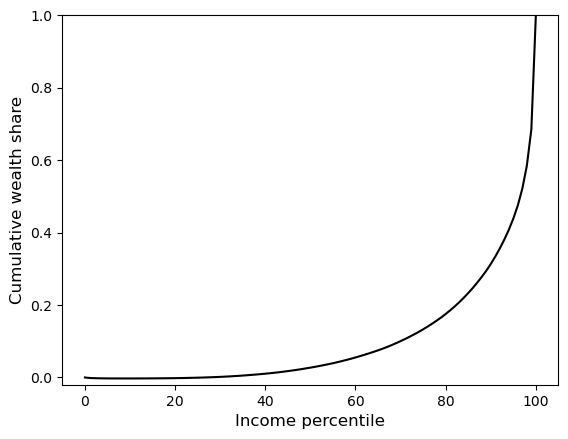

Estimate is center=0.9891294009546624, spread=0.0
Lorenz distance is 42.338409384229536
Average MPC for all consumers is 0.099
Average MPC in the top percentile of W/Y is 0.069
Average MPC in the top decile of W/Y is 0.071
Average MPC in the top quintile of W/Y is 0.072
Average MPC in the second quintile of W/Y is 0.074
Average MPC in the middle quintile of W/Y is 0.074
Average MPC in the fourth quintile of W/Y is 0.076
Average MPC in the bottom quintile of W/Y is 0.197
Average MPC in the top percentile of y is 0.075
Average MPC in the top decile of y is 0.077
Average MPC in the top quintile of y is 0.084
Average MPC in the second quintile of y is 0.117
Average MPC in the middle quintile of y is 0.119
Average MPC in the fourth quintile of y is 0.082
Average MPC in the bottom quintile of y is 0.092
Average MPC for the employed is 0.096
Average MPC for the unemployed is 0.130
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
65.755% are in the bottom wealt

In [4]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
}


EstimationEconomy = estimate(options, parameters)

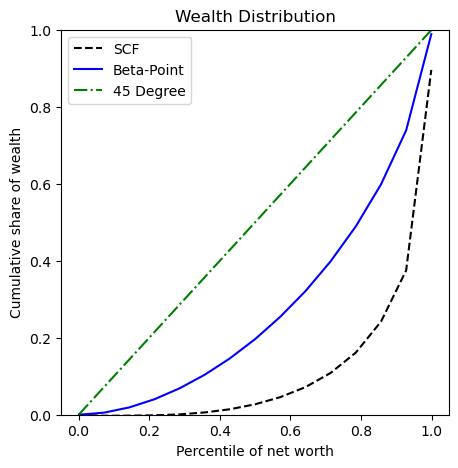

In [5]:
# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)

sim_wealth = EstimationEconomy.reap_state["aLvl"][0]
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)

# Plot
plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points, "-b", label="Beta-Point")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_1")

## Time Preference Heterogeneneity

Our specific approach is to replace the assumption that all households have the same time
preference factor with an assumption that, for some dispersion $\nabla$, time
preference factors are distributed uniformly in the population between
$\grave{\Discount}-\nabla$ and $\grave{\Discount}+\nabla$ (for this reason, the model is referred to as the $\Discount$-Dist model). Then,
using simulations, we search for the values of $\grave{\Discount}$ and
$\nabla$ for which the model best matches the fraction of net worth held by the top $20$, $40$, $60$, and $80$ percent of the population, while at the same time matching
the aggregate capital-to-output ratio from the perfect foresight
model. Specifically, defining $w_{i}$ and $\omega _{i}$ as the proportion of total aggregate net worth held by the top $i$ percent in our model and in the data, respectively, we solve the following minimization problem:

$$
\{\grave{\Discount}, \nabla\}= \underset{\{{\Discount}, \nabla\}}{\text{argmin} }\Big(\sum_\text{i=20, 40, 60, 80}
  \big(w_{i}({\Discount}, \nabla)-\omega _{i}\big)^{2}\Big)^{1/2}
$$

subject to the constraint that the aggregate wealth (net worth)-to-output ratio in the model matches the aggregate
capital-to-output ratio from the perfect foresight model ($\KLev_{PF}/\YLev_{PF}$). When solving the problem for the FBS specification we shut down the aggregate shocks (practically, this does not affect the estimates given their small size).

$$\KLev / \YLev = \KLev_{PF} / \YLev_{PF}$$

The solution to this problem is $\{\grave{\Discount}, \nabla\}=\{0.9867, 0.0067\}$
, so that the discount factors are evenly spread roughly between 0.98 and 0.99. We call the optimal value of the objective function the 'Lorenz distance' and use it as a measure of fit of the models.

The introduction of even such a relatively modest amount of time
preference heterogeneity sharply improves the model's fit to the targeted
proportions of wealth holdings, bringing it reasonably in line with the data.


In [6]:
"""
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
"""
do_param_dist = True  # Do param-dist version if True, param-point if False
do_lifecycle = False  # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False  # Solve the FBS aggregate shocks version of the model
do_liquid = True  # Matches liquid assets data when True, net worth data when False
do_tractable = False  #

Beginning an estimation with the specification name PYbetaDistIndLiquid...
0.9809571428571429
0.9828714285714286
0.9847857142857143
0.9867
0.9886142857142858
0.9905285714285714
0.9924428571428572
get_KY_ratio_difference tried center = 0.9867 and got 3.324835439111082
find_lorenz_distance_at_target_KY tried spread = 0.0067 and got 14.783735216125608
0.9809571528571429
0.9828714385714287
0.9847857242857143
0.9867000100000001
0.9886142957142858
0.9905285814285715
0.9924428671428572
get_KY_ratio_difference tried center = 0.9867000100000001 and got 3.324869574704447
find_lorenz_distance_at_target_KY tried spread = 0.0067 and got 14.783719229597159
0.9809571342857143
0.9828714228571429
0.9847857114285714
0.9867
0.9886142885714286
0.9905285771428571
0.9924428657142857
get_KY_ratio_difference tried center = 0.9867 and got 3.3248560620994123
find_lorenz_distance_at_target_KY tried spread = 0.00670001 and got 14.78369536656191
0.9448571428571428
0.9465714285714285
0.9482857142857143
0.95
0.95171

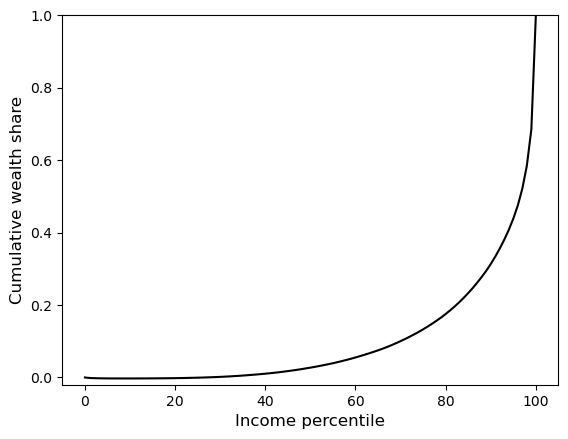

Estimate is center=0.984928790588658, spread=0.008
Lorenz distance is 13.396503969672345
Average MPC for all consumers is 0.253
Average MPC in the top percentile of W/Y is 0.057
Average MPC in the top decile of W/Y is 0.063
Average MPC in the top quintile of W/Y is 0.067
Average MPC in the second quintile of W/Y is 0.102
Average MPC in the middle quintile of W/Y is 0.214
Average MPC in the fourth quintile of W/Y is 0.323
Average MPC in the bottom quintile of W/Y is 0.558
Average MPC in the top percentile of y is 0.235
Average MPC in the top decile of y is 0.227
Average MPC in the top quintile of y is 0.231
Average MPC in the second quintile of y is 0.261
Average MPC in the middle quintile of y is 0.265
Average MPC in the fourth quintile of y is 0.231
Average MPC in the bottom quintile of y is 0.276
Average MPC for the employed is 0.242
Average MPC for the unemployed is 0.393
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
50.768% are in the bottom weal

In [7]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
    "do_combo_estimation": True,
}


EstimationEconomy = estimate(options, parameters)

In [12]:
# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)

sim_wealth = np.asarray(EstimationEconomy.reap_state["aLvl"]).flatten()
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)

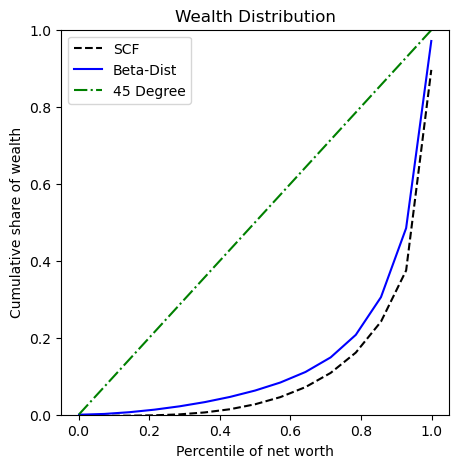

In [13]:
# Plot
plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points, "-b", label="Beta-Dist")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_2")

In [9]:
np.asarray(EstimationEconomy.reap_state["aLvl"]).shape

(7, 2000)